In [ ]:
# Does multi-profile deconvolution (Sharp and Birchall 2010, PASA, sec. 5.2)

In [20]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits

%matplotlib inline

In [21]:
# gaussian profile
def gaus1d(x_pass, mu_pass, sigma_pass):
    
    return (1./(sigma_pass*np.sqrt(2.*np.pi))) * np.exp(-0.5 * np.power((x_pass-mu_pass)/sigma_pass,2.) )

In [31]:
# Yoo-Jung's spectrum (not the broadband one)

hdul = fits.open('./data/stacked.fits')
test_data = hdul[0].data # all 3 spectra
test_data_1 = hdul[0].data[0] # will reduce to just 1 spectrum

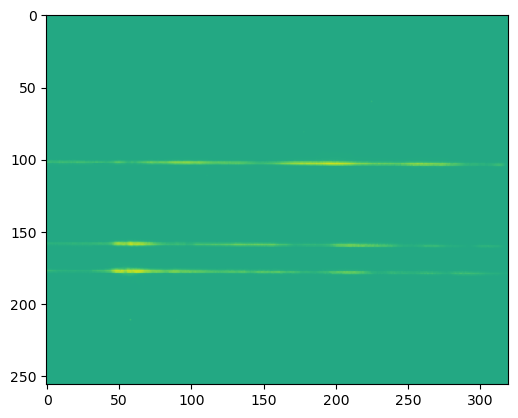

In [23]:
plt.imshow(test_data[0,:,:], norm='log')
plt.show()

In [33]:
# fit an extended Gaussian to the broadband image

array_broadband = test_data[0,:,:]

# ersatz bad pixel mask
y_center_1 = 104
y_center_2 = 160
y_center_3 = 179
test_data_1[0:y_center_1-4,:] = 0
test_data_1[y_center_1+4:,:] = 0

# normalize
test_data_1 = np.divide(test_data_1,np.nanmax(test_data_1))

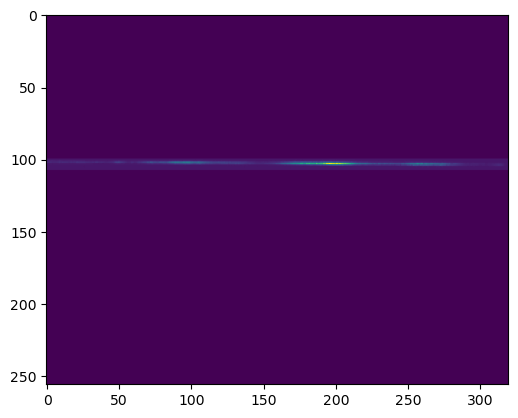

In [35]:
plt.imshow(test_data_1)
plt.show()

In [6]:
# variance array

#array_variance = 1./np.add(array_broadband,0.001) # np.std(cube_bad,axis=2)**2 # ersatz 
array_variance = test_data[1,:,:]

In [7]:
# make the enclosing profile of the spectrum

def simple_profile(y_center, sigma_pass=1):
    # make simple 1D Gaussian profile in x-direction

    array_profile = np.zeros(np.shape(test_data[0,:,:]))
    xgrid, ygrid = np.meshgrid(np.arange(0,np.shape(array_profile)[1]),np.arange(0,np.shape(array_profile)[0]))
    array_profile = gaus1d(x_pass = ygrid, mu_pass = y_center, sigma_pass=sigma_pass)

    # normalize it such that the marginalization in x (in (x,lambda) space) is 1
    # (with a perfect Gaussian profile in x this is redundant)
    array_profile = np.divide(array_profile,np.sum(array_profile, axis=0))
    
    return array_profile

In [10]:
# make profiles for all 3 spectra

simple_profile_1 = simple_profile(y_center=y_center_1)
simple_profile_2 = simple_profile(y_center=y_center_2)
simple_profile_3 = simple_profile(y_center=y_center_3)

In [41]:
D = test_data[0,:,:]

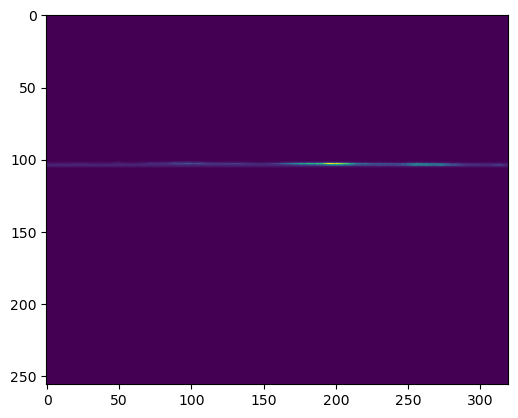

In [49]:
plt.imshow(np.multiply(D,simple_profile_1))
plt.show()

In [52]:
# along 1 column of pixels

x_extent = np.shape(simple_profile_1)[1]

eta_all_cols = np.zeros(x_extent)

# loop over cols
for col in range(0,x_extent): 
    
    c_11 = 0
    b_1 = 0
    
    # loop over pixels
    for i in range(100,101):
    
        c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        b_1 += D[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        #test_data
    
        #Di = test_data # CCD data value at pixel i
        
    # integrated intensity of fiber 1 at the current wavelength element
    eta_1 = b_1/c_11
    
    eta_all_cols[col] = eta_1

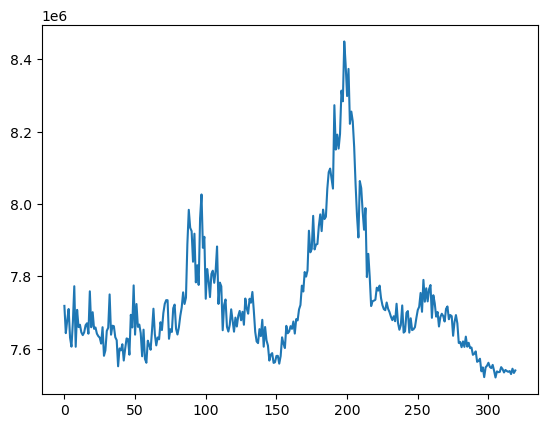

In [55]:
plt.plot(eta_all_cols)
plt.show()